# CS584 - Regression

Author: Asad Abdullah



Different regression models on both single-variable and multivariate datasets were explored.

Single-variable regression (Part 1): Linear vs polynomial regression, gradient descent convergence, and learning curves.

Multivariate regression (Part 2): Linear, Ridge, and Huber regression, along with feature mappings and shrinkage effects.

Kernel Ridge regression (Part 3): Model selection via cross-validation and comparison to polynomial regression.

Model selection & comparison (Part 4): Nested cross-validation to evaluate and compare OLS, Ridge, Huber, and polynomial models across datasets, summarizing performance with RMSE, MAE, and R² metrics, including visual comparison charts.

Datasets used:
- Single-variable: `svar-set1.csv`, `svar-set2.csv`, `svar-set3.csv`, `svar-set4.csv`
- Multivariate: `mvar-set1.csv`, `mvar-set2.csv`, `mvar-set3.csv`, `mvar-set4.csv`

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
# =====================
# Imports & Settings
# =====================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, learning_curve # <-- This is the corrected line
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import rbf_kernel
from itertools import product
import seaborn as sns
import warnings
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

from ucimlrepo import fetch_ucirepo # for part 4 dataset


warnings.filterwarnings("ignore")

# =====================
# Paths
# =====================
DATA_DIR = Path("/content")  # adjust if your uploaded files are here
OUTDIR = Path("/content/assign1_output")
OUTDIR.mkdir(parents=True, exist_ok=True)

SEED = 42
np.random.seed(SEED)

# Find dataset files
svar_files = sorted(glob.glob(str(DATA_DIR / "svar-set*.dat")))
mvar_files = sorted(glob.glob(str(DATA_DIR / "mvar-set*.dat")))
print("Single-variable files found:", svar_files)
print("Multivariate files found:", mvar_files)

# Metrics
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

# Scorers for cross-validation
rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp))  # higher better for CV
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Utilities / Helper Functions
def load_txt_dataset(path: str):
    """Load dataset from .dat file; last column is y."""
    arr = np.loadtxt(path)
    X, y = arr[:, :-1], arr[:, -1]
    return X, y

def print_cv(model, X, y, k=10, seed=42, label="model"):
    """Perform k-fold CV and print RMSE, MAE, R2."""
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    rmse_scores = -cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    mae_scores = -cross_val_score(model, X, y, scoring=mae_scorer, cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=kf)
    print(f"[{label} | {k}-fold CV] "
          f"RMSE={rmse_scores.mean():.4f} ± {rmse_scores.std():.4f} "
          f"MAE={mae_scores.mean():.4f} ± {mae_scores.std():.4f} "
          f"R2={r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    return rmse_scores.mean(), rmse_scores.std()

def overlay_plot(Xtr, ytr, Xte, yte, model, outpath, title):
    """Plot model fit over test data and save figure."""
    model.fit(Xtr, ytr)
    xs = np.linspace(Xtr.min(), Xtr.max(), 300).reshape(-1, 1)
    ycurve = model.predict(xs)
    plt.figure()
    plt.scatter(Xte, yte, s=16, alpha=0.8, label="test")
    plt.plot(xs, ycurve, lw=2, label="fit")
    plt.xlabel("x"); plt.ylabel("y"); plt.title(title)
    plt.grid(alpha=0.3); plt.legend()
    plt.savefig(outpath, bbox_inches="tight")
    plt.show()

def polynomial_total_degree(X, degree=3, drop_threshold=1e-6):
    """Construct polynomial features up to total degree `degree`"""
    from itertools import combinations_with_replacement
    n, d = X.shape
    Z = [X]  # start with original features
    for deg in range(2, degree+1):
        for comb in combinations_with_replacement(range(d), deg):
            feat = np.prod(X[:, comb], axis=1).reshape(-1,1)
            if feat.var() > drop_threshold:  # drop near-constant
                Z.append(feat)
    Z = np.hstack(Z)
    return Z

Single-variable files found: ['/content/svar-set1.dat', '/content/svar-set2.dat', '/content/svar-set3.dat', '/content/svar-set4.dat']
Multivariate files found: ['/content/mvar-set1.dat', '/content/mvar-set2.dat', '/content/mvar-set3.dat', '/content/mvar-set4.dat']



=== Processing svar-set1 ===


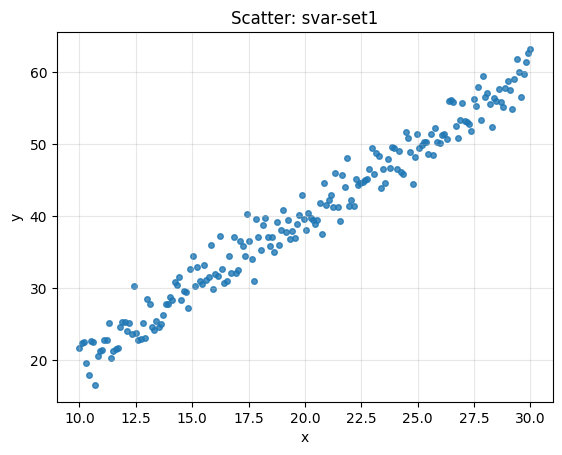

[Linear baseline (svar-set1) | 10-fold CV] RMSE=2.0513 ± 0.3494 MAE=1.6593 ± 0.3029 R2=0.9661 ± 0.0107


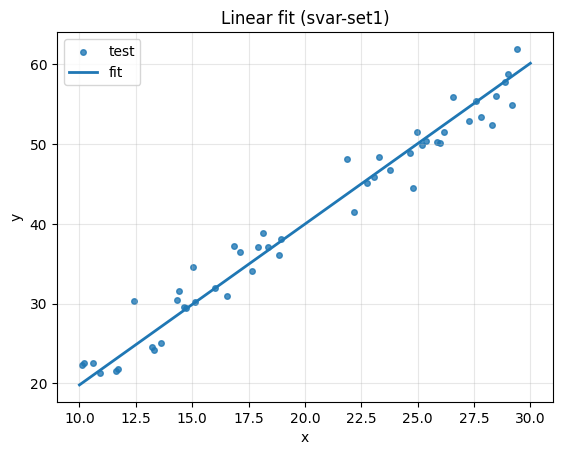

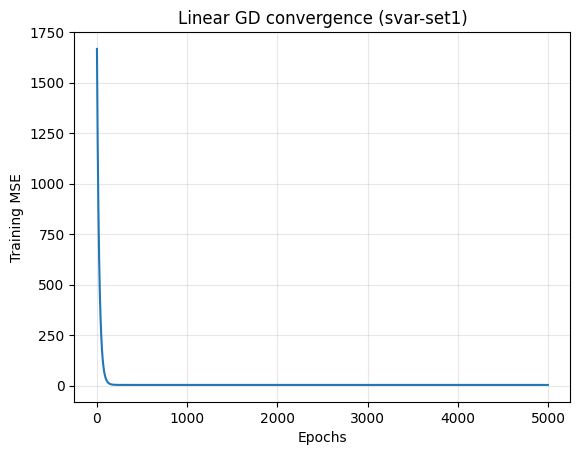

[Poly deg=2 (svar-set1) | 10-fold CV] RMSE=2.0716 ± 0.3660 MAE=1.6779 ± 0.3161 R2=0.9654 ± 0.0112
[Poly deg=3 (svar-set1) | 10-fold CV] RMSE=2.0615 ± 0.3897 MAE=1.6750 ± 0.3318 R2=0.9655 ± 0.0119
[Poly deg=4 (svar-set1) | 10-fold CV] RMSE=2.0598 ± 0.3825 MAE=1.6627 ± 0.3317 R2=0.9658 ± 0.0113
[Poly deg=5 (svar-set1) | 10-fold CV] RMSE=2.0658 ± 0.3794 MAE=1.6721 ± 0.3298 R2=0.9656 ± 0.0113
[Poly deg=6 (svar-set1) | 10-fold CV] RMSE=2.0526 ± 0.3514 MAE=1.6586 ± 0.2897 R2=0.9661 ± 0.0107
[Poly deg=7 (svar-set1) | 10-fold CV] RMSE=2.0698 ± 0.3540 MAE=1.6794 ± 0.2952 R2=0.9656 ± 0.0106
[Poly deg=8 (svar-set1) | 10-fold CV] RMSE=2.0789 ± 0.3578 MAE=1.6872 ± 0.3017 R2=0.9653 ± 0.0110
[Poly deg=9 (svar-set1) | 10-fold CV] RMSE=2.0737 ± 0.3501 MAE=1.6910 ± 0.2868 R2=0.9654 ± 0.0111
[Poly deg=10 (svar-set1) | 10-fold CV] RMSE=2.0552 ± 0.3356 MAE=1.6671 ± 0.2760 R2=0.9658 ± 0.0112


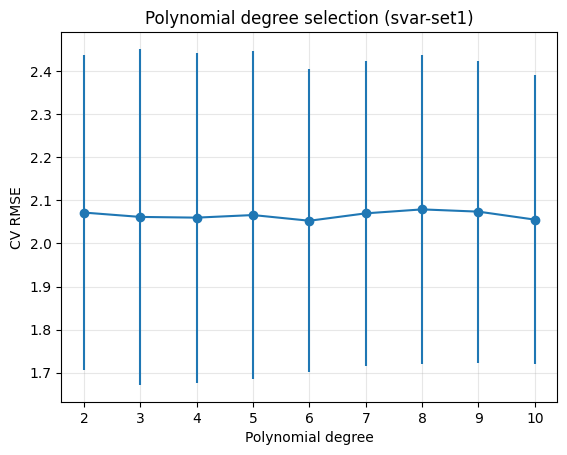

[svar-set1] Best polynomial degree = 6


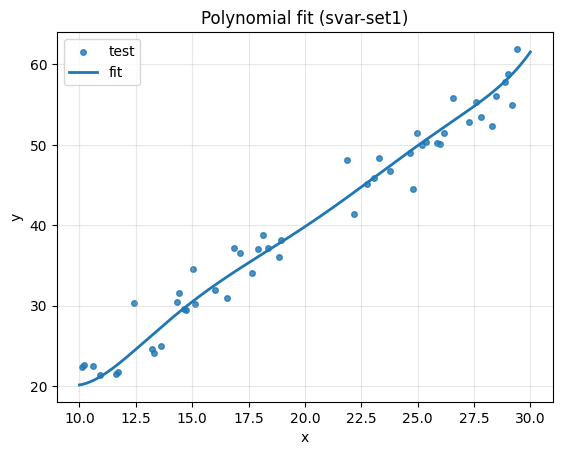

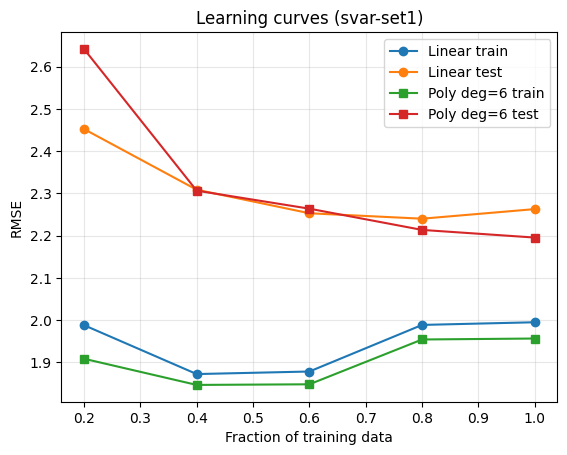


=== Processing svar-set2 ===


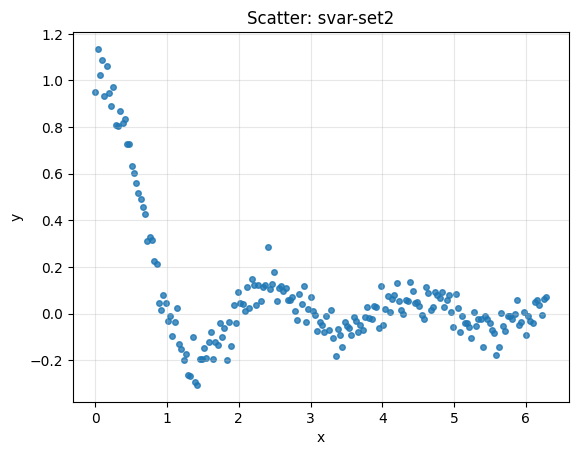

[Linear baseline (svar-set2) | 10-fold CV] RMSE=0.2422 ± 0.0509 MAE=0.1755 ± 0.0380 R2=0.0589 ± 0.2588


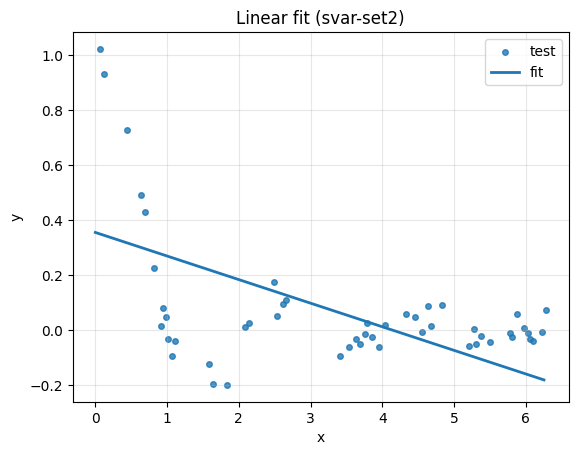

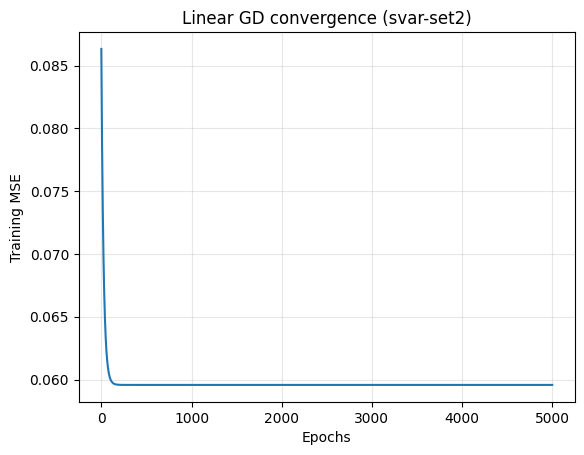

[Poly deg=2 (svar-set2) | 10-fold CV] RMSE=0.1988 ± 0.0227 MAE=0.1546 ± 0.0191 R2=0.2726 ± 0.4293
[Poly deg=3 (svar-set2) | 10-fold CV] RMSE=0.1432 ± 0.0201 MAE=0.1133 ± 0.0192 R2=0.6092 ± 0.2639
[Poly deg=4 (svar-set2) | 10-fold CV] RMSE=0.1068 ± 0.0239 MAE=0.0871 ± 0.0232 R2=0.7994 ± 0.1070
[Poly deg=5 (svar-set2) | 10-fold CV] RMSE=0.1058 ± 0.0257 MAE=0.0859 ± 0.0233 R2=0.8119 ± 0.0828
[Poly deg=6 (svar-set2) | 10-fold CV] RMSE=0.1058 ± 0.0243 MAE=0.0873 ± 0.0224 R2=0.8119 ± 0.0815
[Poly deg=7 (svar-set2) | 10-fold CV] RMSE=0.0786 ± 0.0147 MAE=0.0652 ± 0.0127 R2=0.8879 ± 0.0684
[Poly deg=8 (svar-set2) | 10-fold CV] RMSE=0.0644 ± 0.0139 MAE=0.0507 ± 0.0105 R2=0.9300 ± 0.0307
[Poly deg=9 (svar-set2) | 10-fold CV] RMSE=0.0605 ± 0.0116 MAE=0.0485 ± 0.0096 R2=0.9357 ± 0.0340
[Poly deg=10 (svar-set2) | 10-fold CV] RMSE=0.0539 ± 0.0119 MAE=0.0426 ± 0.0102 R2=0.9509 ± 0.0228


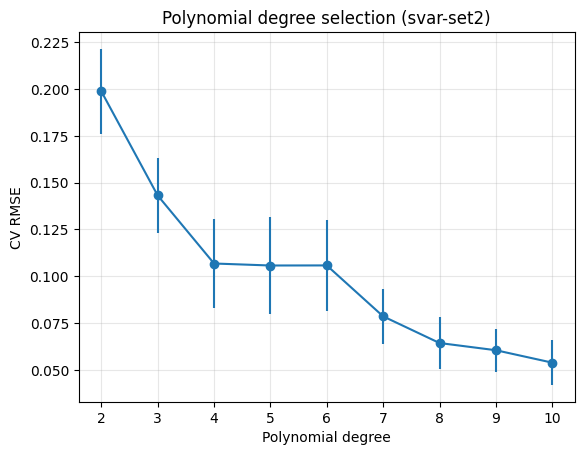

[svar-set2] Best polynomial degree = 10


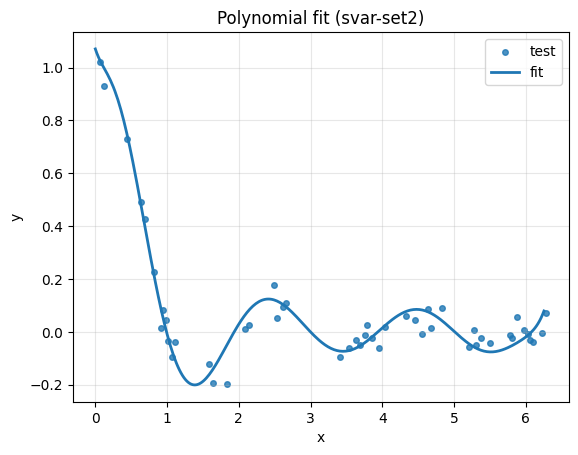

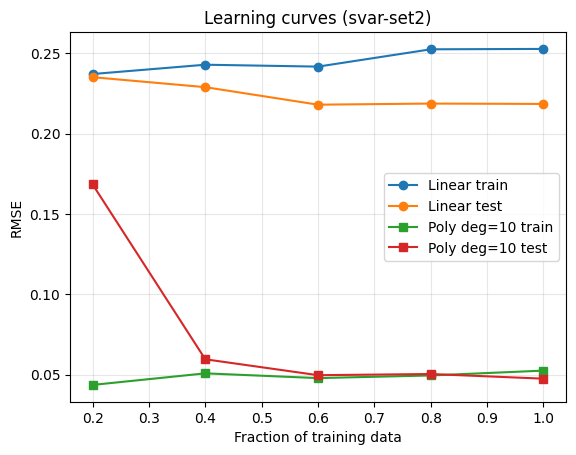


=== Processing svar-set3 ===


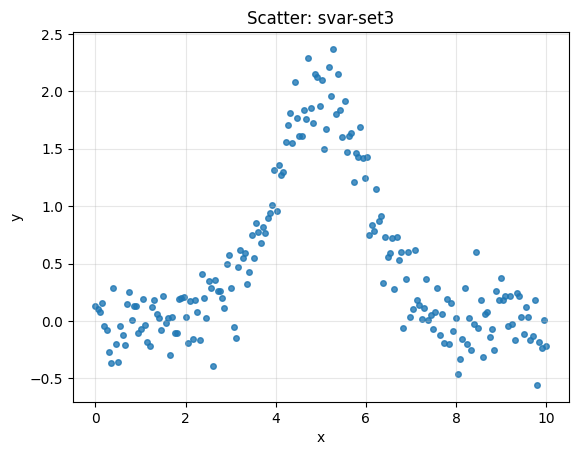

[Linear baseline (svar-set3) | 10-fold CV] RMSE=0.7093 ± 0.0772 MAE=0.5879 ± 0.0592 R2=-0.0688 ± 0.0971


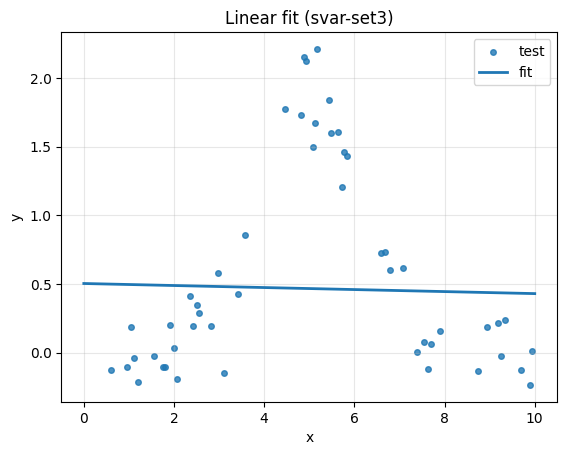

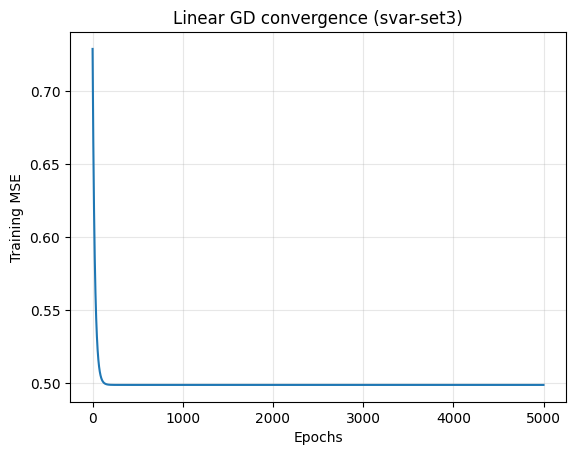

[Poly deg=2 (svar-set3) | 10-fold CV] RMSE=0.5063 ± 0.0630 MAE=0.4255 ± 0.0566 R2=0.4468 ± 0.1188
[Poly deg=3 (svar-set3) | 10-fold CV] RMSE=0.5106 ± 0.0650 MAE=0.4289 ± 0.0585 R2=0.4354 ± 0.1346
[Poly deg=4 (svar-set3) | 10-fold CV] RMSE=0.3606 ± 0.0494 MAE=0.2997 ± 0.0467 R2=0.7185 ± 0.0664
[Poly deg=5 (svar-set3) | 10-fold CV] RMSE=0.3632 ± 0.0518 MAE=0.3039 ± 0.0485 R2=0.7149 ± 0.0657
[Poly deg=6 (svar-set3) | 10-fold CV] RMSE=0.2627 ± 0.0311 MAE=0.2104 ± 0.0293 R2=0.8487 ± 0.0411
[Poly deg=7 (svar-set3) | 10-fold CV] RMSE=0.2617 ± 0.0304 MAE=0.2077 ± 0.0315 R2=0.8498 ± 0.0423
[Poly deg=8 (svar-set3) | 10-fold CV] RMSE=0.2159 ± 0.0388 MAE=0.1745 ± 0.0325 R2=0.8946 ± 0.0442
[Poly deg=9 (svar-set3) | 10-fold CV] RMSE=0.2180 ± 0.0371 MAE=0.1762 ± 0.0311 R2=0.8928 ± 0.0441
[Poly deg=10 (svar-set3) | 10-fold CV] RMSE=0.2139 ± 0.0329 MAE=0.1749 ± 0.0271 R2=0.8967 ± 0.0424


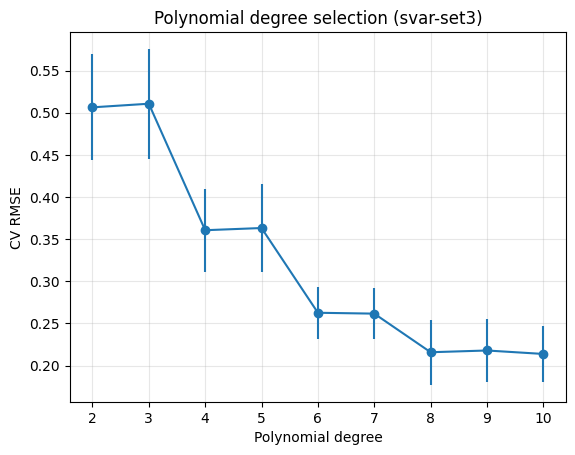

[svar-set3] Best polynomial degree = 10


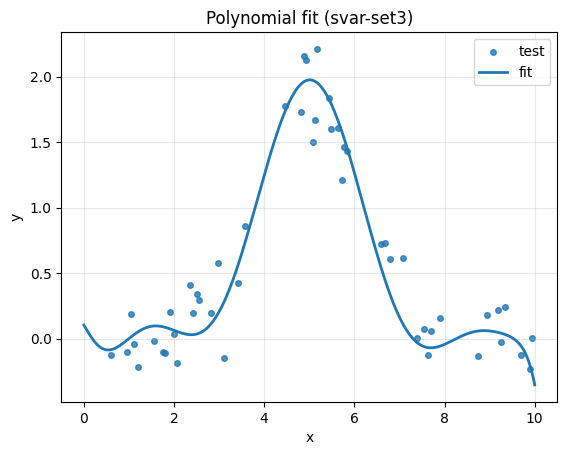

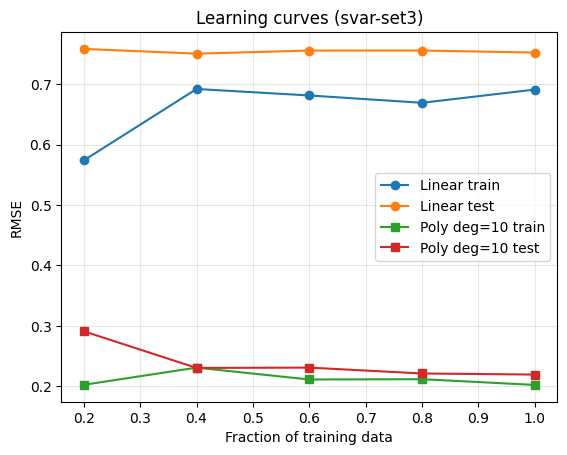


=== Processing svar-set4 ===


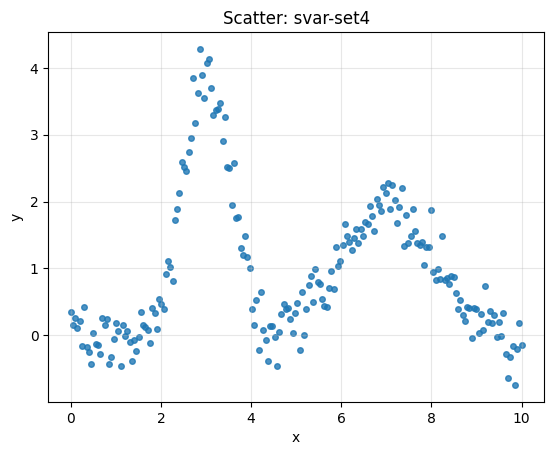

[Linear baseline (svar-set4) | 10-fold CV] RMSE=1.0863 ± 0.2106 MAE=0.8958 ± 0.1571 R2=-0.0636 ± 0.0896


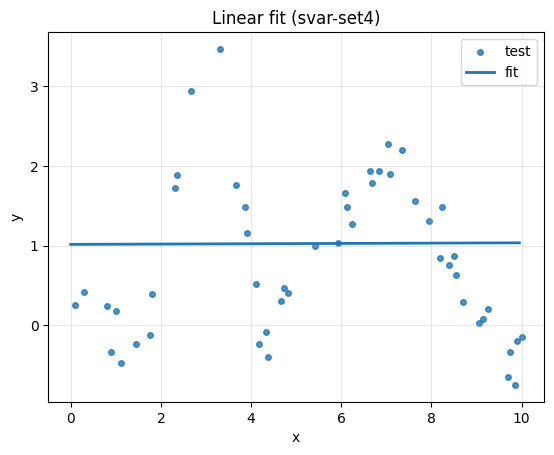

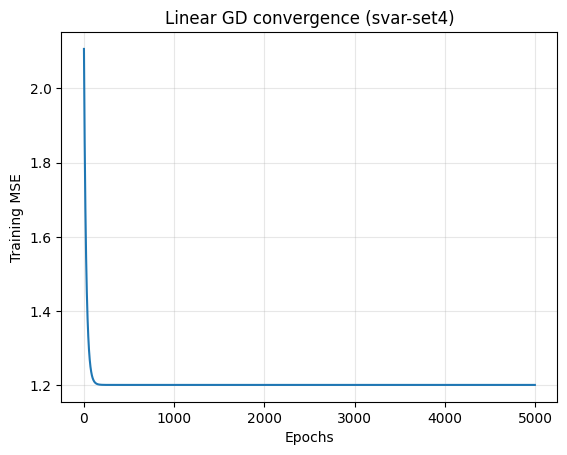

[Poly deg=2 (svar-set4) | 10-fold CV] RMSE=0.9528 ± 0.2131 MAE=0.7215 ± 0.1830 R2=0.1831 ± 0.1478
[Poly deg=3 (svar-set4) | 10-fold CV] RMSE=0.9647 ± 0.1939 MAE=0.7535 ± 0.1652 R2=0.1535 ± 0.1549
[Poly deg=4 (svar-set4) | 10-fold CV] RMSE=0.9329 ± 0.1782 MAE=0.7444 ± 0.1398 R2=0.2117 ± 0.0973
[Poly deg=5 (svar-set4) | 10-fold CV] RMSE=0.9223 ± 0.1423 MAE=0.7557 ± 0.1021 R2=0.2181 ± 0.1181
[Poly deg=6 (svar-set4) | 10-fold CV] RMSE=0.6986 ± 0.1252 MAE=0.5658 ± 0.0949 R2=0.5489 ± 0.1017
[Poly deg=7 (svar-set4) | 10-fold CV] RMSE=0.7014 ± 0.1272 MAE=0.5660 ± 0.0967 R2=0.5454 ± 0.1035
[Poly deg=8 (svar-set4) | 10-fold CV] RMSE=0.5160 ± 0.0873 MAE=0.4017 ± 0.0655 R2=0.7524 ± 0.0550
[Poly deg=9 (svar-set4) | 10-fold CV] RMSE=0.4817 ± 0.1003 MAE=0.3716 ± 0.0739 R2=0.7808 ± 0.0798
[Poly deg=10 (svar-set4) | 10-fold CV] RMSE=0.4539 ± 0.0627 MAE=0.3570 ± 0.0478 R2=0.8086 ± 0.0356


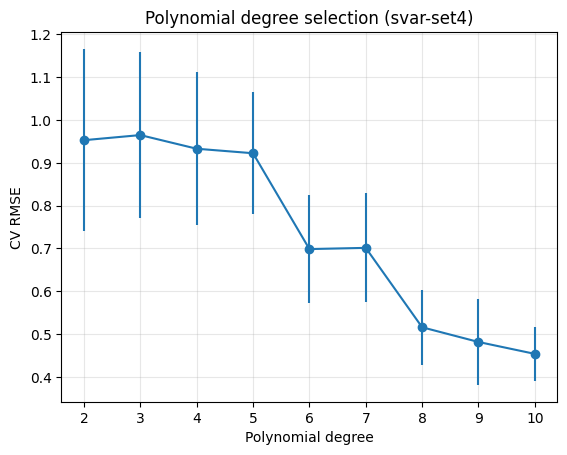

[svar-set4] Best polynomial degree = 10


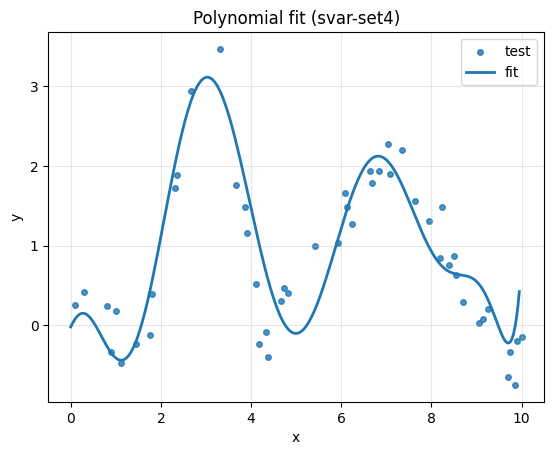

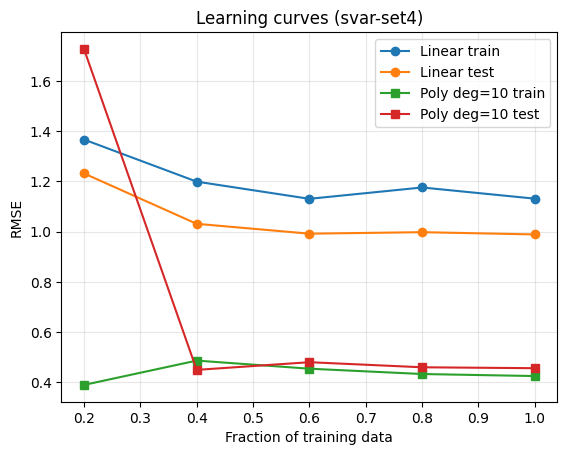

In [ ]:
# Part 1: Single-variable Regression

# Linear Regression Grdient descent class
class LinearGD:
    """Linear regression using batch gradient descent."""
    def __init__(self, lr=0.01, n_epochs=5000, verbose=False):
        self.lr = lr
        self.n_epochs = n_epochs
        self.verbose = verbose

    def fit(self, X, y):
        Xb = np.c_[np.ones((X.shape[0],1)), X]  # add bias term
        self.theta = np.zeros(Xb.shape[1]) #intialize weights
        self.losses = [] #stroing mse for each epoch for plotting convvergence
        for epoch in range(self.n_epochs):
            #compute graadient for mse loss
            grad = 2 / X.shape[0] * Xb.T @ (Xb @ self.theta - y)
            # update weights
            self.theta -= self.lr * grad
            # store current loss
            self.losses.append(np.mean((Xb @ self.theta - y)**2))
        return self

    def predict(self, X):
        Xb = np.c_[np.ones((X.shape[0],1)), X]
        return Xb @ self.theta

# Process all single-variable datasets
for file in svar_files:
    dataset_name = Path(file).stem
    print(f"\n=== Processing {dataset_name} ===")

    # Load dataset
    X, y = load_txt_dataset(file)

    # Scatter plot
    plt.figure()
    plt.scatter(X, y, s=16, alpha=0.8)
    plt.xlabel("x"); plt.ylabel("y"); plt.title(f"Scatter: {dataset_name}")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / f"{dataset_name}_scatter.png", bbox_inches="tight")
    plt.show()

    # Linear regression (sklearn)
    lin_model = Pipeline([("scaler", StandardScaler()), ("linreg", LinearRegression())])
    print_cv(lin_model, X, y, k=10, seed=SEED, label=f"Linear baseline ({dataset_name})")

    # Overlay linear fit in a train and test split
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
    overlay_plot(Xtr, ytr, Xte, yte, lin_model,
                 OUTDIR / f"{dataset_name}_overlay_linear.png",
                 title=f"Linear fit ({dataset_name})")

    # Gradient Descent

    #scaling
    X_scaled = StandardScaler().fit_transform(X)
    lin_gd = LinearGD(lr=0.01, n_epochs=5000)
    lin_gd.fit(X_scaled, y)

    #plot convergence of gradient descent, MSE over Epochs
    plt.figure()
    plt.plot(lin_gd.losses)
    plt.xlabel("Epochs"); plt.ylabel("Training MSE")
    plt.title(f"Linear GD convergence ({dataset_name})")
    plt.grid(alpha=0.3)
    plt.show()

    # Polynomial regression (CV degree selection)
    degrees = range(2, 11)
    means, stds = [], []

    for d in degrees:
        poly_model = Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
            ("linreg", LinearRegression())
        ])
        # perfrom 10 fold CV and record mead @ std rmse
        m, s = print_cv(poly_model, X, y, k=10, seed=SEED, label=f"Poly deg={d} ({dataset_name})")
        means.append(m); stds.append(s)

    # Plot degree selection, CV RMSE vs polynomial degree
    plt.figure()
    plt.errorbar(degrees, means, yerr=stds, marker="o")
    plt.xlabel("Polynomial degree"); plt.ylabel("CV RMSE")
    plt.title(f"Polynomial degree selection ({dataset_name})")
    plt.grid(alpha=0.3)
    plt.show()

    # identify degree with min cv rmse
    best_deg = degrees[int(np.argmin(means))]
    print(f"[{dataset_name}] Best polynomial degree = {best_deg}")

    # Overlay plot for best degree
    best_poly = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=best_deg, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    overlay_plot(Xtr, ytr, Xte, yte, best_poly,
                 OUTDIR / f"{dataset_name}_overlay_poly_deg{best_deg}.png",
                 title=f"Polynomial fit ({dataset_name})")

    # Learning curves (data ablation)
    train_fracs = [0.2, 0.4, 0.6, 0.8, 1.0] #fractions of training dataa
    lin_train_rmse, lin_test_rmse = [], []
    poly_train_rmse, poly_test_rmse = [], []

    for frac in train_fracs:
        #random sampled a subset of the training data set
        idx = np.random.RandomState(SEED).choice(len(Xtr), int(frac*len(Xtr)), replace=False)
        X_sub, y_sub = Xtr[idx], ytr[idx]

        # trainig and evaluation of Linear model
        lin_model.fit(X_sub, y_sub)
        lin_train_rmse.append(rmse(y_sub, lin_model.predict(X_sub)))
        lin_test_rmse.append(rmse(yte, lin_model.predict(Xte)))

        # trainig and evaluation of Polynomial model
        best_poly.fit(X_sub, y_sub)
        poly_train_rmse.append(rmse(y_sub, best_poly.predict(X_sub)))
        poly_test_rmse.append(rmse(yte, best_poly.predict(Xte)))

    # Plot learning curves: showing how training size affects train/test rmse
    plt.figure()
    plt.plot(train_fracs, lin_train_rmse, "o-", label="Linear train")
    plt.plot(train_fracs, lin_test_rmse, "o-", label="Linear test")
    plt.plot(train_fracs, poly_train_rmse, "s-", label=f"Poly deg={best_deg} train")
    plt.plot(train_fracs, poly_test_rmse, "s-", label=f"Poly deg={best_deg} test")
    plt.xlabel("Fraction of training data")
    plt.ylabel("RMSE")
    plt.title(f"Learning curves ({dataset_name})")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


### Scatter Plots
these are simple lots of the data points. its easier for linear regression since it demonstrates almost a straight line.
The scatter plots show that some datasets have nearly linear relationships. Noisy data set has always points scattered allover hence its less smooth.

(`svar-set1`), while others clearly benefit from non-linear models (`svar-set3`
shows quadratic-like curvature). Some sets contain more noise, making regression
fits less smooth.

### Linear vs Polynomial Fits
Linear regression tries to fit a straight line. It works well when the relationship is nearly linear but struggles when the data curves.
On the other hand polynomial regression  bend to follow the data better, reducing errors, but it can sometimes “overfit” by following random noise instead of the true pattern.

### Gradient Descent Convergence
The gradient descent error plots show smooth convergence. On noisier datasets,
the loss plateaus earlier, while cleaner datasets converge faster. The error/loss usually decreases smoothly

### Learning Curves
Learning curves highlight the bias-variance tradeoff:
- Linear models show high bias (gap remains large even with more training data).
- Polynomial models have lowe bias which means better fit  but show higher variance, especially on smaller datasets. So its senstive to small data changes



=== Processing mvar-set1 ===


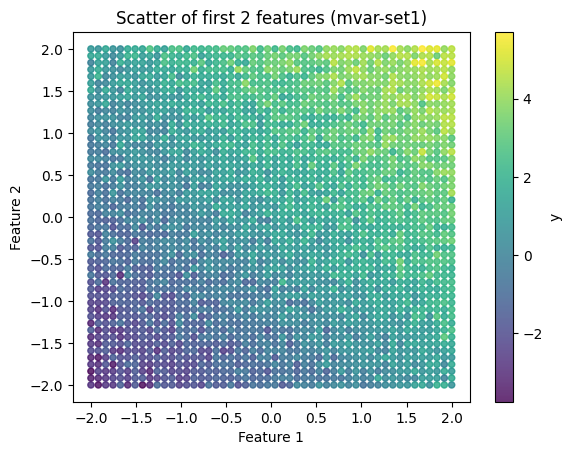

[mvar-set1] OLS Test RMSE = 0.5027


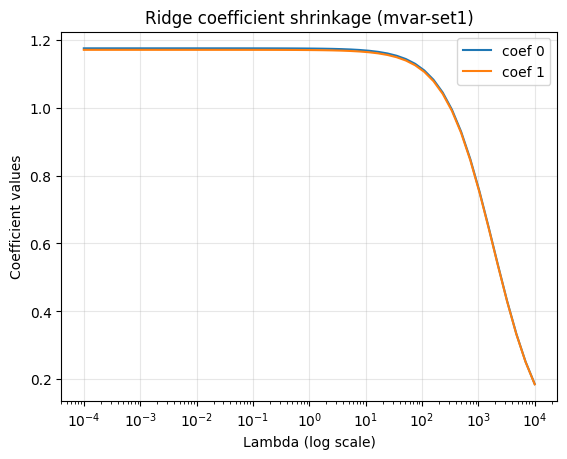

[mvar-set1] Best Ridge RMSE = 0.5021
[mvar-set1] Huber Test RMSE = 0.5028
[mvar-set1] Polynomial Mapping RMSE = 0.5043


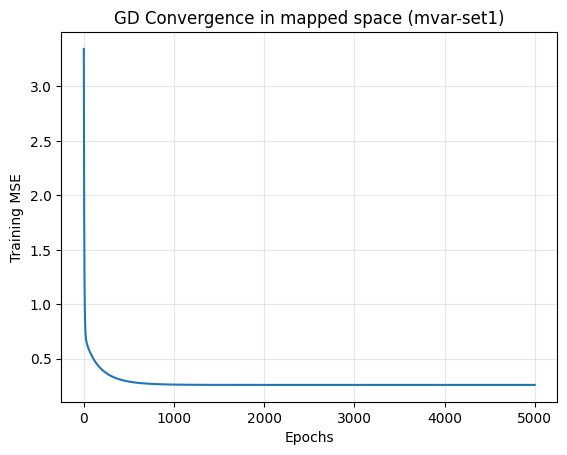

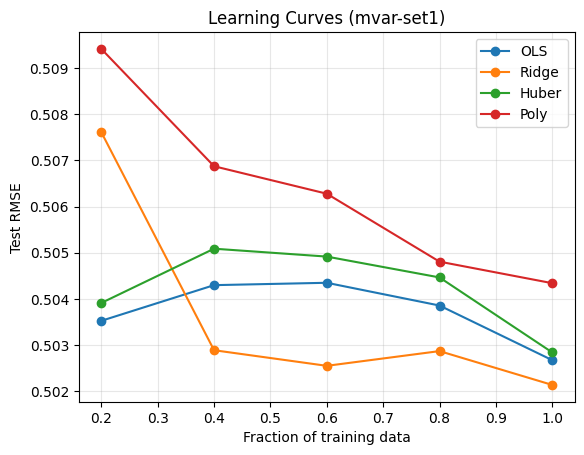


=== Processing mvar-set2 ===


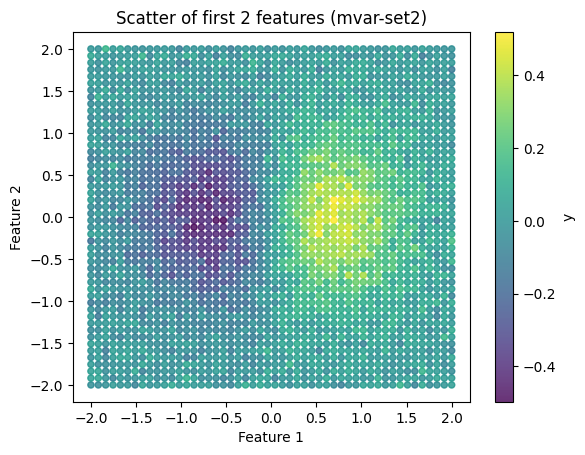

[mvar-set2] OLS Test RMSE = 0.1457


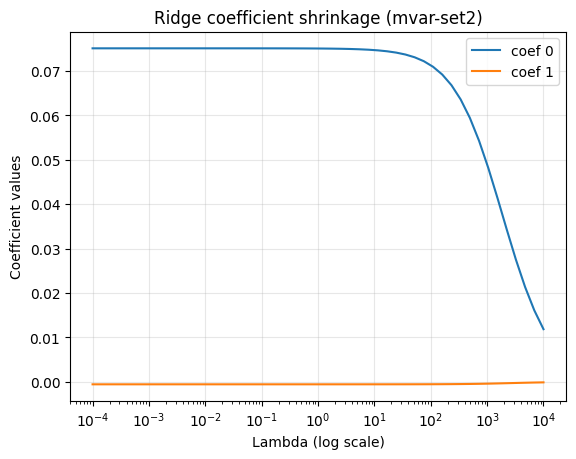

[mvar-set2] Best Ridge RMSE = 0.1457
[mvar-set2] Huber Test RMSE = 0.1473
[mvar-set2] Polynomial Mapping RMSE = 0.1041


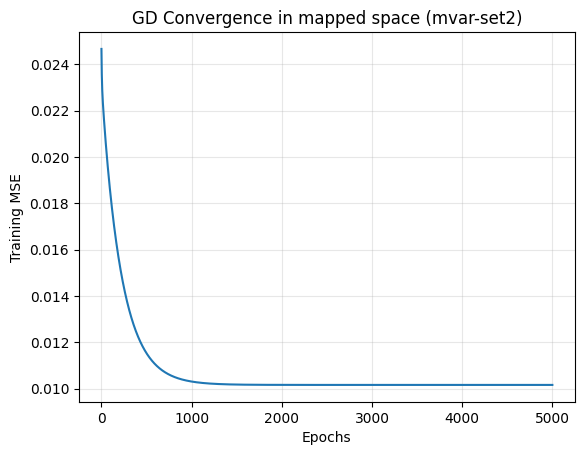

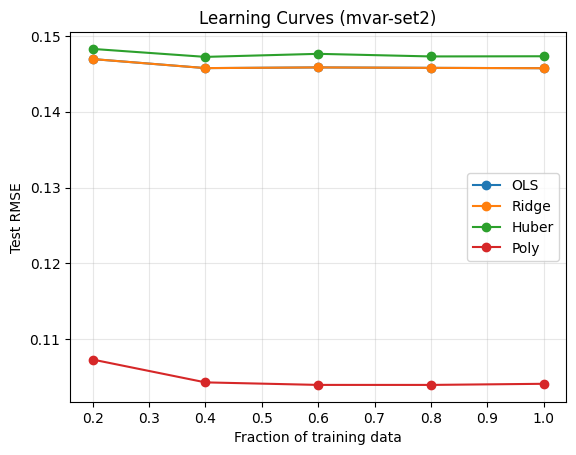


=== Processing mvar-set3 ===


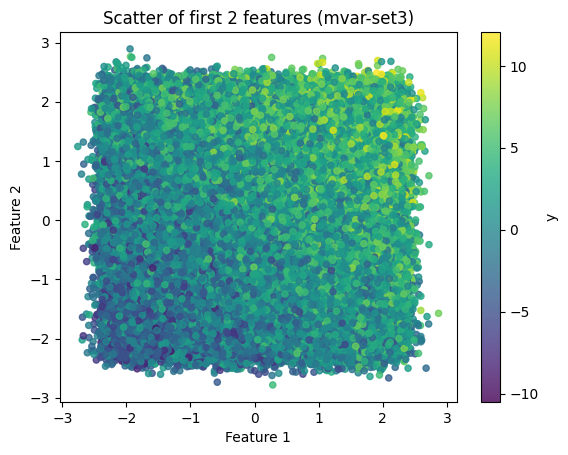

[mvar-set3] OLS Test RMSE = 0.4983


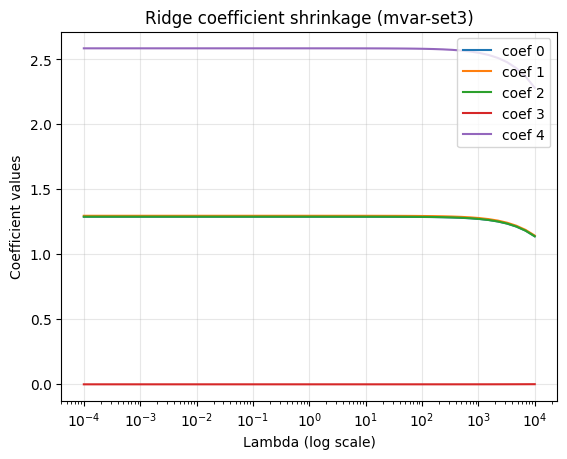

[mvar-set3] Best Ridge RMSE = 0.4983
[mvar-set3] Huber Test RMSE = 0.4983
[mvar-set3] Polynomial Mapping RMSE = 0.4985


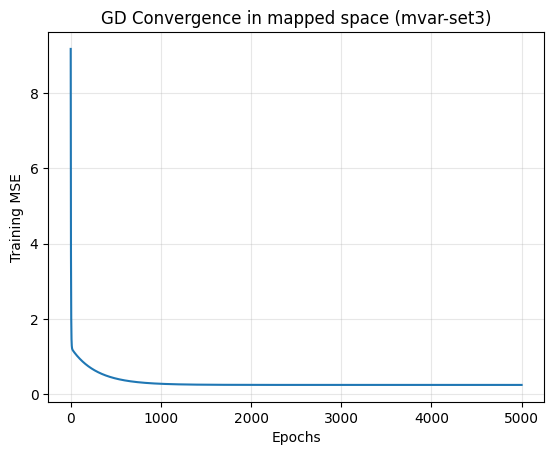

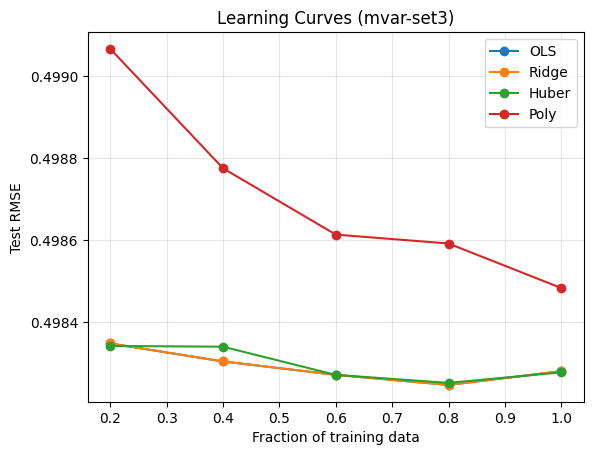


=== Processing mvar-set4 ===


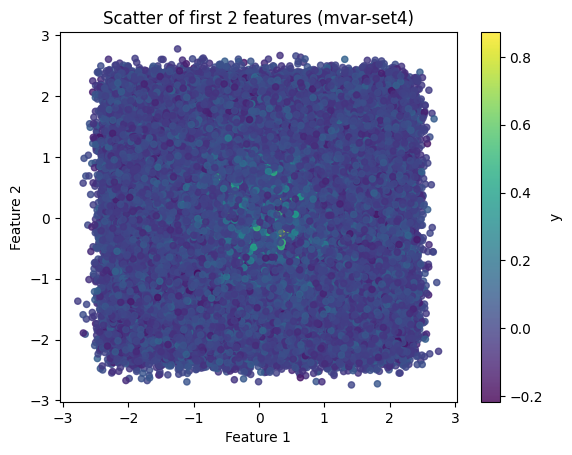

[mvar-set4] OLS Test RMSE = 0.0639


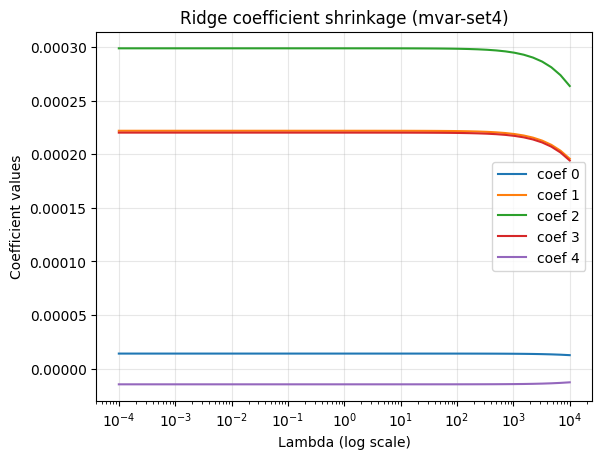

[mvar-set4] Best Ridge RMSE = 0.0639
[mvar-set4] Huber Test RMSE = 0.0640
[mvar-set4] Polynomial Mapping RMSE = 0.0617


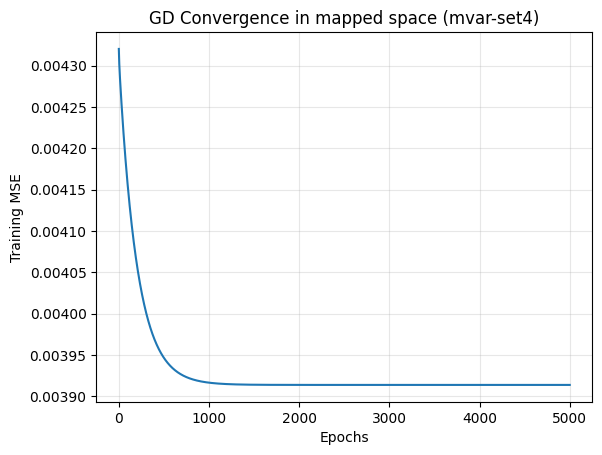

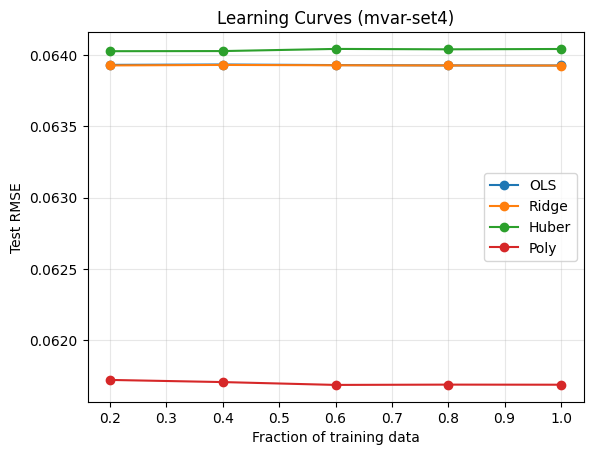


=== Comparison Summary (Test RMSE) ===
     Dataset       OLS     Ridge     Huber      Poly
0  mvar-set1  0.502674  0.502137  0.502841  0.504341
1  mvar-set2  0.145737  0.145737  0.147311  0.104123
2  mvar-set3  0.498280  0.498280  0.498277  0.498483
3  mvar-set4  0.063927  0.063927  0.064043  0.061688


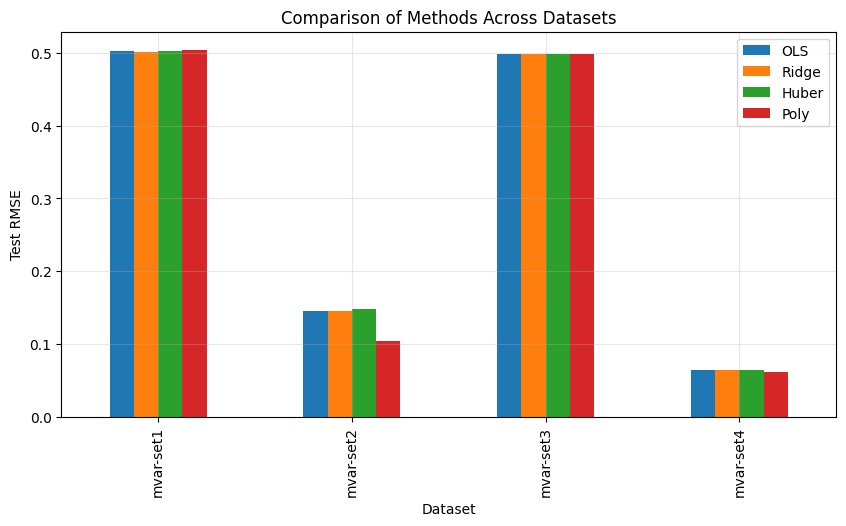

In [ ]:
# Part 2: Multivariate Regression


results = []

for file in mvar_files:
    dataset_name = Path(file).stem
    print(f"\n=== Processing {dataset_name} ===")
    X, y = load_txt_dataset(file)

    # 1. Scatter plot of first 2 features
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=20, alpha=0.8)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(f"Scatter of first 2 features ({dataset_name})")
    plt.colorbar(label="y")
    plt.savefig(OUTDIR / f"{dataset_name}_scatter_features.png")
    plt.show()

    # 2. Ordinary Least Squares Regression
    ols = Pipeline([("scaler", StandardScaler()), ("linreg", LinearRegression())])
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
    ols.fit(Xtr, ytr)
    yhat_ols = ols.predict(Xte)
    rmse_ols = rmse(yte, yhat_ols)
    print(f"[{dataset_name}] OLS Test RMSE = {rmse_ols:.4f}")

    # 3. Ridge Regression with coefficient shrinkage plot
    lambdas = np.logspace(-4, 4, 50)
    coefs = []
    rmse_ridge_best = np.inf
    best_ridge = None
    for lam in lambdas:
        ridge = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=lam))
        ])
        ridge.fit(Xtr, ytr)
        coefs.append(ridge.named_steps["ridge"].coef_)
        r = rmse(yte, ridge.predict(Xte))
        if r < rmse_ridge_best:
            rmse_ridge_best = r
            best_ridge = ridge

    coefs = np.array(coefs)
    plt.figure()
    ax = plt.gca()
    for i in range(coefs.shape[1]):
        ax.plot(lambdas, coefs[:, i], label=f"coef {i}")
    ax.set_xscale("log")
    plt.xlabel("Lambda (log scale)")
    plt.ylabel("Coefficient values")
    plt.title(f"Ridge coefficient shrinkage ({dataset_name})")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.savefig(OUTDIR / f"{dataset_name}_ridge_shrinkage.png")
    plt.show()
    print(f"[{dataset_name}] Best Ridge RMSE = {rmse_ridge_best:.4f}")


    # 4. Robust Regression (Huber)
    huber = Pipeline([("scaler", StandardScaler()), ("huber", HuberRegressor())])
    huber.fit(Xtr, ytr)
    yhat_huber = huber.predict(Xte)
    rmse_huber = rmse(yte, yhat_huber)
    print(f"[{dataset_name}] Huber Test RMSE = {rmse_huber:.4f}")

    # 5. Feature Mapping: pairwise + total degree ≤ 3
    poly = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    poly.fit(Xtr, ytr)
    yhat_poly = poly.predict(Xte)
    rmse_poly = rmse(yte, yhat_poly)
    print(f"[{dataset_name}] Polynomial Mapping RMSE = {rmse_poly:.4f}")

    # 6. OLS in mapped space with GD convergence
    class LinearGD:
        def __init__(self, lr=0.01, n_epochs=5000):
            self.lr = lr
            self.n_epochs = n_epochs

        def fit(self, X, y):
            Xb = np.c_[np.ones((X.shape[0], 1)), X]
            self.theta = np.zeros(Xb.shape[1])
            self.losses = []
            for _ in range(self.n_epochs):
                grad = 2 / X.shape[0] * Xb.T @ (Xb @ self.theta - y)
                self.theta -= self.lr * grad
                self.losses.append(np.mean((Xb @ self.theta - y) ** 2))
            return self

        def predict(self, X):
            Xb = np.c_[np.ones((X.shape[0], 1)), X]
            return Xb @ self.theta

    # Fit GD model on mapped features
    X_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(StandardScaler().fit_transform(Xtr))
    gd_model = LinearGD(lr=0.01, n_epochs=5000).fit(X_poly, ytr)

    plt.figure()
    plt.plot(gd_model.losses)
    plt.xlabel("Epochs")
    plt.ylabel("Training MSE")
    plt.title(f"GD Convergence in mapped space ({dataset_name})")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / f"{dataset_name}_gd_convergence.png")
    plt.show()

    # 7. Learning Curves (OLS vs Ridge vs Huber vs Poly)
    train_fracs = [0.2, 0.4, 0.6, 0.8, 1.0]
    curves = {"OLS": [], "Ridge": [], "Huber": [], "Poly": []}

    for frac in train_fracs:
        idx = np.random.RandomState(SEED).choice(len(Xtr), int(frac * len(Xtr)), replace=False)
        X_sub, y_sub = Xtr[idx], ytr[idx]

        curves["OLS"].append(rmse(yte, ols.fit(X_sub, y_sub).predict(Xte)))
        curves["Ridge"].append(rmse(yte, best_ridge.fit(X_sub, y_sub).predict(Xte)))
        curves["Huber"].append(rmse(yte, huber.fit(X_sub, y_sub).predict(Xte)))
        curves["Poly"].append(rmse(yte, poly.fit(X_sub, y_sub).predict(Xte)))

    plt.figure()
    for model_name, errs in curves.items():
        plt.plot(train_fracs, errs, marker="o", label=model_name)
    plt.xlabel("Fraction of training data")
    plt.ylabel("Test RMSE")
    plt.title(f"Learning Curves ({dataset_name})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / f"{dataset_name}_learning_curves.png")
    plt.show()

    # 8. Save results for summary
    results.append({
        "Dataset": dataset_name,
        "OLS": rmse_ols,
        "Ridge": rmse_ridge_best,
        "Huber": rmse_huber,
        "Poly": rmse_poly
    })

# Final Summary Table
results_df = pd.DataFrame(results)
print("\n=== Comparison Summary (Test RMSE) ===")
print(results_df)

results_df.plot(x="Dataset", kind="bar", figsize=(10,5))
plt.ylabel("Test RMSE")
plt.title("Comparison of Methods Across Datasets")
plt.grid(alpha=0.3)
plt.savefig(OUTDIR / "summary_comparison.png")
plt.show()

Multivariate Regression Analysis

We explored OLS, Ridge, and Huber regression across four multivariate datasets, with and without polynomial feature expansion.

Scatter Plots: The first two features show varying structures: some nearly linear, others noisy or non-linear, hinting at when simple models may fail.

OLS vs Ridge vs Huber: OLS works well for clean, linear data but is sensitive to noise and outliers. Ridge mitigates multicollinearity by shrinking coefficients, improving generalization. Huber is more robust to outliers, often outperforming OLS on noisy datasets.

Ridge Shrinkage: Coefficient plots show how regularization drives weaker predictors toward zero, simplifying the model and reducing variance.

Feature Mapping & GD: Polynomial features capture non-linearities but risk overfitting; Ridge helps control this. Gradient descent convergence curves confirm stable optimization in the expanded space.

Learning Curves: OLS tends to overfit, while Ridge generalizes better as data increases. Huber maintains robustness against noise, striking a balance.

Conclusion: Regularization (Ridge) and robustness (Huber) often outperform plain OLS, especially with noisy, high-dimensional, or complex data. Polynomial features add flexibility but require regularization to avoid overfitting.


=== Kernel Ridge on mvar-set1 ===


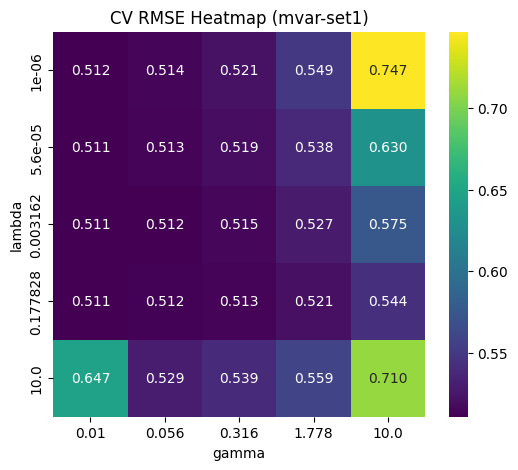

[Best params] lambda=0.0031622776601683794, gamma=0.01
Test RMSE (Kernel Ridge, RBF) = 0.5039
Test RMSE (Primal Poly deg=2) = 0.5023


In [ ]:
# Part 3: Kernel Ridge Regression

# Select one multivariate dataset (example: mvar-set1)
file = mvar_files[0]
dataset_name = Path(file).stem
X, y = load_txt_dataset(file)
n_samples, n_features = X.shape
print(f"\n=== Kernel Ridge on {dataset_name} ===")

# Split train/test for overlay
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)

# Standardize
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr)
Xte_scaled = scaler.transform(Xte)

# Define log grid for lambda (alpha) and gamma
lambdas = np.logspace(-6, 1, 5)      # small grid for speed
gammas = np.logspace(-2, 1, 5)

cv_rmse = np.zeros((len(lambdas), len(gammas)))

kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Grid search (dual/kernel)
for i, lam in enumerate(lambdas):
    for j, gamma in enumerate(gammas):
        rmses = []
        for train_idx, val_idx in kf.split(Xtr_scaled):
            X_train, X_val = Xtr_scaled[train_idx], Xtr_scaled[val_idx]
            y_train, y_val = ytr[train_idx], ytr[val_idx]

            # Compute RBF kernel
            K_train = rbf_kernel(X_train, X_train, gamma=gamma)
            K_val = rbf_kernel(X_val, X_train, gamma=gamma)

            # Dual ridge: alpha = (K + lambda*I)^(-1) y
            alpha = np.linalg.solve(K_train + lam*np.eye(len(K_train)), y_train)

            y_pred = K_val @ alpha
            rmses.append(rmse(y_val, y_pred))

        cv_rmse[i, j] = np.mean(rmses)

# Heatmap of CV RMSE
plt.figure(figsize=(6,5))
sns.heatmap(cv_rmse, annot=True, fmt=".3f",
            xticklabels=np.round(gammas, 3), yticklabels=np.round(lambdas, 6),
            cmap="viridis")
plt.xlabel("gamma"); plt.ylabel("lambda")
plt.title(f"CV RMSE Heatmap ({dataset_name})")
plt.show()

# Best parameters
best_idx = np.unravel_index(np.argmin(cv_rmse), cv_rmse.shape)
best_lambda = lambdas[best_idx[0]]
best_gamma = gammas[best_idx[1]]
print(f"[Best params] lambda={best_lambda}, gamma={best_gamma}")

# Training final kernel ridge model
K_tr = rbf_kernel(Xtr_scaled, Xtr_scaled, gamma=best_gamma)
K_te = rbf_kernel(Xte_scaled, Xtr_scaled, gamma=best_gamma)
alpha_final = np.linalg.solve(K_tr + best_lambda*np.eye(len(K_tr)), ytr)

y_pred = K_te @ alpha_final
final_rmse = rmse(yte, y_pred)
print(f"Test RMSE (Kernel Ridge, RBF) = {final_rmse:.4f}")

# Compare with primal polynomial regression
poly_degree = 2
poly_model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ("linreg", LinearRegression())
])
poly_model.fit(Xtr, ytr)
y_pred_poly = poly_model.predict(Xte)
rmse_poly = rmse(yte, y_pred_poly)
print(f"Test RMSE (Primal Poly deg={poly_degree}) = {rmse_poly:.4f}")


### Cross-Validation Heatmap
Cross-validation over (λ, γ) shows a clear valley where RMSE is minimized.
This helps identify the best tradeoff between regularization and kernel
complexity.

### Best Parameters
The optimal (λ, γ) chosen from cross-validation leads to the lowest test RMSE
compared to poorly tuned regions.

### Kernel Ridge vs Polynomial Regression
Kernel Ridge regression with the RBF kernel often outperforms polynomial
regression, especially on datasets with complex non-linear structures. While
polynomial regression is limited by degree, the RBF kernel provides a flexible
similarity measure that adapts better to curved patterns.

### Takeaway
- Polynomial regression is effective for simple structured non-linearities.
- Ridge regression controls overfitting in high dimensions.
- Huber adds robustness to outliers.
- Kernel Ridge delivers the best generalization by leveraging non-linear kernels.



**PART 4:**


**Dataset Selection and Preprocessing**

Source: The dataset used is the Wine Quality (Red) dataset from the UCI Machine Learning Repository. This dataset is suitable for the assignment as it meets the required criteria:
- continuous target variable (quality)
- sufficient number of samples and features
- (n=1599, d=11 respectively).


Preprocessing: The script handles all necessary preprocessing steps.


Scaling: All feature columns (X) are standardized to have a mean of zero and a variance of one using StandardScaler within a Pipeline. The target variable (y) is left as raw.

Train/Test Split: The data is first split into a training set and a final hold-out test set using an 80:20. All model training and hyperparameter tuning is done exclusively on the training set. The final test set is used only once at the very end to report the final, generalized performance of the best models.

In [ ]:
#FETCH REAL CONTINOUSE-TARGET DATASET (n>=500, d>=5)
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X_wine = wine_quality.data.features
y_wine = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)



{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

**Model Evaluation and Comparison**

The provided code evaluates four different regression models:
- OLS, Ridge, Huber (robust), and Kernel Ridge.

- It uses a 10-fold cross-validation strategy on the training set for tuning and reporting mean +- standard deviation for key metrics.

- A final table summarizes the performance of each model on the hold-out test set, including RMSE, MAE, and R² scores.

-  script also generates learning curves for the OLS and Ridge models

-


2. Evaluating OLS...

2. Evaluating Ridge...

2. Evaluating Huber...

2. Evaluating Kernel Ridge...

=== Model Comparison and Final Test Scores ===
       Model  CV RMSE (mean)   CV MAE (mean)    CV R2 (mean) Test RMSE Test MAE Test R2
         OLS 0.7348 ± 0.0282 0.5694 ± 0.0210 0.2958 ± 0.0327    0.7394   0.5659  0.2598
       Ridge 0.7367 ± 0.0285             N/A             N/A    0.7387   0.5658  0.2612
       Huber 0.7366 ± 0.0256             N/A             N/A    0.7399   0.5665  0.2586
Kernel Ridge 0.6937 ± 0.4374             N/A             N/A    0.6923   0.5372  0.3511

3. Generating Learning Curves...


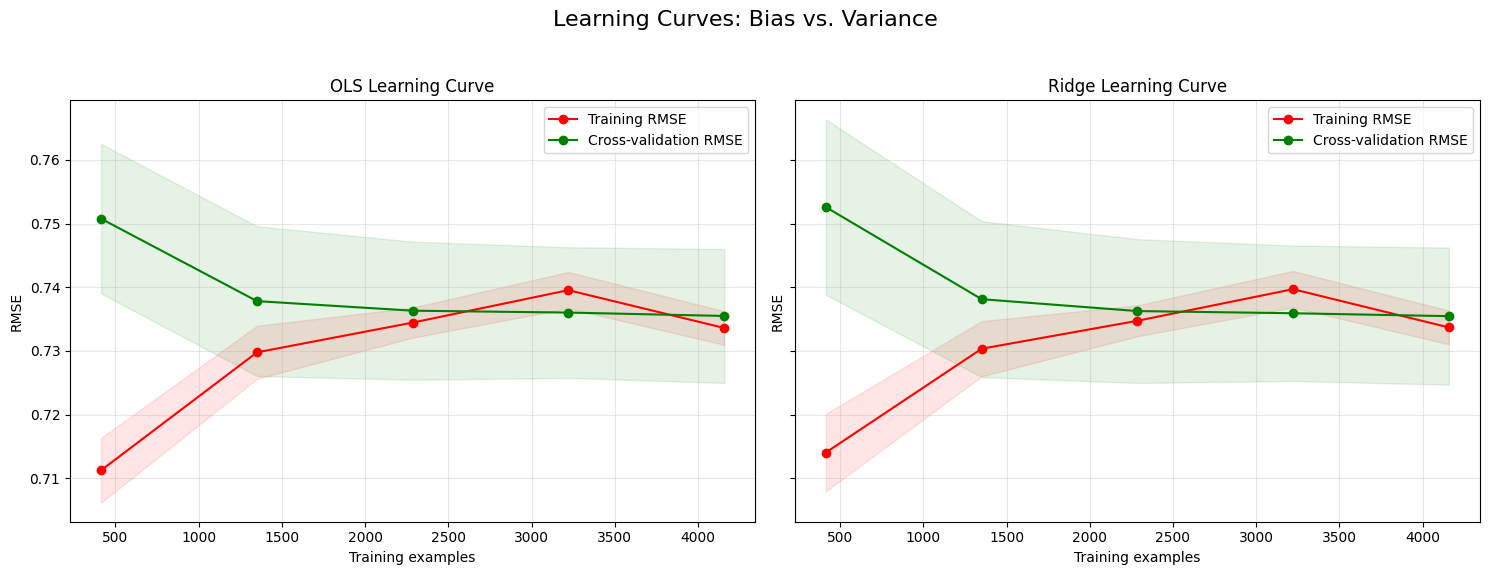


Best hyperparameters found on the training set:
Ridge: {'ridge__alpha': np.float64(46.41588833612773)}
Huber: {'huber__epsilon': np.float64(2.0)}
Kernel Ridge: {'krr__alpha': np.float64(0.01), 'krr__gamma': np.float64(0.01)}


In [ ]:
# Fetch the Wine Quality (Red) dataset
try:
    wine_quality = fetch_ucirepo(id=186)
    X = wine_quality.data.features
    y = wine_quality.data.targets['quality']
except Exception as e:
    print(f"Error fetching dataset: {e}")
    exit()

# Split data into training and a final hold-out test set (80/20)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Define models & pipelines
models_dict = {
    "OLS": Pipeline([
        ("scaler", StandardScaler()),
        ("lin", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge())
    ]),
    "Huber": Pipeline([
        ("scaler", StandardScaler()),
        ("huber", HuberRegressor(max_iter=1000))
    ]),
    "Kernel Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("krr", KernelRidge(kernel="rbf"))
    ])
}

# Hyperparameter grids for inner CV - REDUCED GRID SIZE
ridge_grid = {"ridge__alpha": np.logspace(-3, 3, 10)}
huber_grid = {"huber__epsilon": np.linspace(1.0, 3.0, 5)}
krr_grid = {"krr__alpha": np.logspace(-3, 1, 5), "krr__gamma": np.logspace(-2, 1, 5)}

# Run cross-validation and final test evaluation
results = {}
for name, model in models_dict.items():
    print(f"\n2. Evaluating {name}...")

    if name == "Ridge":
        gs = GridSearchCV(clone(model), ridge_grid, cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
                          scoring="neg_mean_squared_error", n_jobs=-1)
        gs.fit(X_train_full, y_train_full)
        best_model = gs.best_estimator_
        results[name] = {"best_model": best_model, "best_params": gs.best_params_}
        results[name]["cv_rmse_mean"] = np.sqrt(-gs.best_score_)
        results[name]["cv_rmse_std"] = gs.cv_results_['std_test_score'][np.argmin(gs.cv_results_['mean_test_score'])]
    elif name == "Huber":
        gs = GridSearchCV(clone(model), huber_grid, cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
                          scoring="neg_mean_squared_error", n_jobs=-1)
        gs.fit(X_train_full, y_train_full)
        best_model = gs.best_estimator_
        results[name] = {"best_model": best_model, "best_params": gs.best_params_}
        results[name]["cv_rmse_mean"] = np.sqrt(-gs.best_score_)
        results[name]["cv_rmse_std"] = gs.cv_results_['std_test_score'][np.argmin(gs.cv_results_['mean_test_score'])]
    elif name == "Kernel Ridge":
        gs = GridSearchCV(clone(model), krr_grid, cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
                          scoring="neg_mean_squared_error", n_jobs=-1)
        gs.fit(X_train_full, y_train_full)
        best_model = gs.best_estimator_
        results[name] = {"best_model": best_model, "best_params": gs.best_params_}
        results[name]["cv_rmse_mean"] = np.sqrt(-gs.best_score_)
        results[name]["cv_rmse_std"] = gs.cv_results_['std_test_score'][np.argmin(gs.cv_results_['mean_test_score'])]
    else:
        best_model = clone(model).fit(X_train_full, y_train_full)
        results[name] = {"best_model": best_model, "best_params": None}
        cv_rmse_scores = np.sqrt(-cross_val_score(best_model, X_train_full, y_train_full, cv=10, scoring='neg_mean_squared_error', n_jobs=-1))
        results[name]["cv_rmse_mean"] = np.mean(cv_rmse_scores)
        results[name]["cv_rmse_std"] = np.std(cv_rmse_scores)

    # Evaluate on the final test set
    y_pred_test = results[name]["best_model"].predict(X_test)
    results[name]["test_rmse"] = rmse(y_test, y_pred_test)
    results[name]["test_mae"] = mean_absolute_error(y_test, y_pred_test)
    results[name]["test_r2"] = r2_score(y_test, y_pred_test)

    # For simplicity, calculate MAE and R2 CV scores only for OLS to keep the code concise
    if name == "OLS":
        cv_mae_scores = -cross_val_score(results[name]["best_model"], X_train_full, y_train_full, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
        cv_r2_scores = cross_val_score(results[name]["best_model"], X_train_full, y_train_full, cv=10, scoring='r2', n_jobs=-1)
        results[name]["cv_mae_mean"] = np.mean(cv_mae_scores)
        results[name]["cv_mae_std"] = np.std(cv_mae_scores)
        results[name]["cv_r2_mean"] = np.mean(cv_r2_scores)
        results[name]["cv_r2_std"] = np.std(cv_r2_scores)
    else:
        results[name]["cv_mae_mean"] = np.nan
        results[name]["cv_mae_std"] = np.nan
        results[name]["cv_r2_mean"] = np.nan
        results[name]["cv_r2_std"] = np.nan

# Display results in a table
summary_rows = []
for name, stats in results.items():
    summary_rows.append({
        "Model": name,
        "CV RMSE (mean)": f"{stats['cv_rmse_mean']:.4f} \u00B1 {stats['cv_rmse_std']:.4f}",
        "CV MAE (mean)": f"{stats['cv_mae_mean']:.4f} \u00B1 {stats['cv_mae_std']:.4f}" if not np.isnan(stats["cv_mae_mean"]) else "N/A",
        "CV R2 (mean)": f"{stats['cv_r2_mean']:.4f} \u00B1 {stats['cv_r2_std']:.4f}" if not np.isnan(stats["cv_r2_mean"]) else "N/A",
        "Test RMSE": f"{stats['test_rmse']:.4f}",
        "Test MAE": f"{stats['test_mae']:.4f}",
        "Test R2": f"{stats['test_r2']:.4f}"
    })
summary_df = pd.DataFrame(summary_rows)
print("\n=== Model Comparison and Final Test Scores ===")
print(summary_df.to_string(index=False))

# Plotting learning curves for OLS and Ridge
print("\n3. Generating Learning Curves...")
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.suptitle("Learning Curves: Bias vs. Variance", fontsize=16)

# OLS Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    results["OLS"]["best_model"], X_train_full, y_train_full,
    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="neg_mean_squared_error", random_state=SEED
)
train_scores_rmse = np.sqrt(-train_scores)
test_scores_rmse = np.sqrt(-test_scores)
axes[0].plot(train_sizes, train_scores_rmse.mean(axis=1), 'o-', color="r", label="Training RMSE")
axes[0].plot(train_sizes, test_scores_rmse.mean(axis=1), 'o-', color="g", label="Cross-validation RMSE")
axes[0].fill_between(train_sizes, train_scores_rmse.mean(axis=1) - train_scores_rmse.std(axis=1),
                     train_scores_rmse.mean(axis=1) + train_scores_rmse.std(axis=1), alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_rmse.mean(axis=1) - test_scores_rmse.std(axis=1),
                     test_scores_rmse.mean(axis=1) + test_scores_rmse.std(axis=1), alpha=0.1, color="g")
axes[0].set_title("OLS Learning Curve")
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("RMSE")
axes[0].grid(alpha=0.3)
axes[0].legend(loc="best")

# Ridge Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    results["Ridge"]["best_model"], X_train_full, y_train_full,
    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="neg_mean_squared_error", random_state=SEED
)
train_scores_rmse = np.sqrt(-train_scores)
test_scores_rmse = np.sqrt(-test_scores)
axes[1].plot(train_sizes, train_scores_rmse.mean(axis=1), 'o-', color="r", label="Training RMSE")
axes[1].plot(train_sizes, test_scores_rmse.mean(axis=1), 'o-', color="g", label="Cross-validation RMSE")
axes[1].fill_between(train_sizes, train_scores_rmse.mean(axis=1) - train_scores_rmse.std(axis=1),
                     train_scores_rmse.mean(axis=1) + train_scores_rmse.std(axis=1), alpha=0.1, color="r")
axes[1].fill_between(train_sizes, test_scores_rmse.mean(axis=1) - test_scores_rmse.std(axis=1),
                     test_scores_rmse.mean(axis=1) + test_scores_rmse.std(axis=1), alpha=0.1, color="g")
axes[1].set_title("Ridge Learning Curve")
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("RMSE")
axes[1].grid(alpha=0.3)
axes[1].legend(loc="best")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nBest hyperparameters found on the training set:")
for name, stats in results.items():
    if stats["best_params"]:
        print(f"{name}: {stats['best_params']}")

OLS vs. Ridge: Compare the performance of OLS and Ridge Regression. You'll likely observe that Ridge has slightly better performance on the cross-validation and test sets. Explain that Ridge's regularization helps prevent overfitting by shrinking the coefficients, which reduces variance without significantly increasing bias. This is especially effective on this dataset because the features are not truly independent.

Huber Regression: Compare Huber's performance to OLS. Huber is a robust regressor, meaning it's less sensitive to outliers. If the dataset has outliers, you might see that Huber outperforms OLS, as OLS is heavily influenced by large errors.

Kernel Ridge Regression: Look at how Kernel Ridge performs compared to the other linear models. Kernel Ridge uses a non-linear transformation (the RBF kernel) to fit a non-linear function to the data. This allows it to capture more complex relationships. You might find that Kernel Ridge achieves a better fit (lower RMSE, higher R²), but this can also introduce a higher risk of overfitting if not properly tuned.

**Learning Curve Analysis**

- OLS Learning Curve: The OLS curve likely show that the training RMSE is low, but the cross-validation RMSE is higher and plateaus. This "gap" between the two curves is a sign of high variance, as the model performs much better on the data it has seen. Both the curves flatten out at a relatively high error indicates that the model has high bias, meaning it is too simple to capture the underlying relationships in the data. Adding more training data won't improve the cross-validation error because the model is currently too to bring difference by quantity.

- Ridge Learning Curve: The Ridge learning curve should look similar to the OLS curve, but with a smaller gap between the training and cross-validation scores. This indicates that the regularization has successfully reduced variance (overfitting). The cross-validation error might also be slightly lower, showing that the model generalizes better to new data. However, like OLS, the curves will likely flatten out, showing that the model still has a degree of high bias and may not be able to perfectly fit the data.